## Import Dependencies

In [1]:
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation

In [3]:
# Read in the index csv
df_index = pd.read_csv("/kaggle/input/lego-minifigures-classification/index.csv")
df_index.head()

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1


In [4]:
# Read in the test_csv
df_test = pd.read_csv("/kaggle/input/lego-minifigures-classification/test.csv")
df_test.head()

,path,class_id
0,test/001.jpg,32
1,test/002.jpg,32
2,test/003.jpg,32
3,test/004.jpg,32
4,test/005.jpg,1


In [5]:
# Change the path to be the absolute path
DIRECTORY = "/kaggle/input/lego-minifigures-classification/"
df_index["path"] = DIRECTORY + df_index["path"]
df_test["path"] = DIRECTORY + df_test["path"]

In [6]:
# Create one dataframe of all the image paths
df = pd.concat([df_index, df_test])
df.head()

,path,class_id
0,/kaggle/input/lego-minifigures-classification/...,1
1,/kaggle/input/lego-minifigures-classification/...,1
2,/kaggle/input/lego-minifigures-classification/...,1
3,/kaggle/input/lego-minifigures-classification/...,1
4,/kaggle/input/lego-minifigures-classification/...,1


In [7]:
# Visualize a few images
def visualize_images(images_data:pd.DataFrame, num_imgs:int = 4):
    """
    Takes in the dataframe containing the paths of all images and visualizing num_imgs
    """
    sample_imgs = images_data.sample(num_imgs, ignore_index = True) # Sample images
    num_rows = math.ceil(num_imgs / 4)
    fig = plt.figure(figsize = (10,10))
    for i, row in sample_imgs.iterrows():
        img_path = row["path"] 
        img = plt.imread(img_path)
        
        # Plot image
        ax = fig.add_subplot(num_rows, 4, i + 1)
        ax.imshow(img)
        
    fig.tight_layout()
    fig.show()

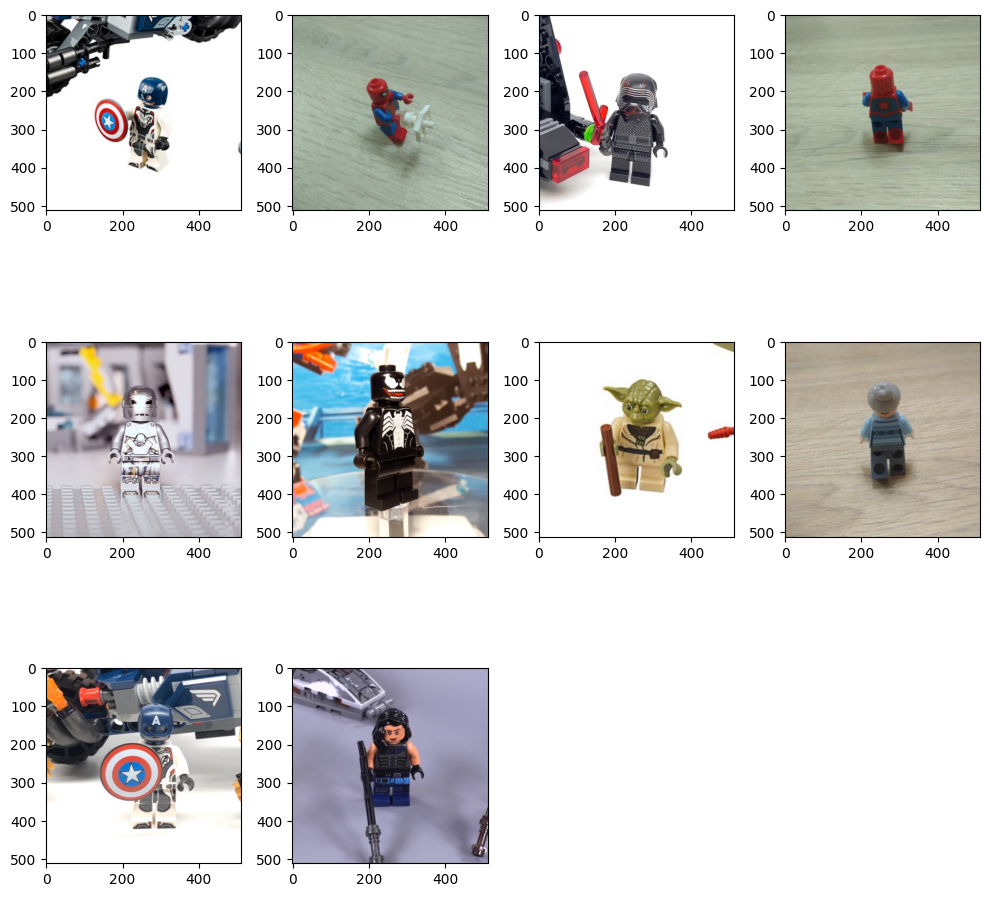

In [8]:
# Visualize images
visualize_images(df, num_imgs = 10)

In [9]:
# Create the custom dataset class
class LEGODataset(Dataset):
    def __init__(self, img_df, transforms = None):
        self.img_df = img_df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_df)
    
    def __getitem__(self, idx):
        img_path = self.img_df.iloc[idx]["path"]
        img = Image.open(img_path).convert("RGB")
        label = self.img_df.iloc[idx]["class_id"]
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, label

In [10]:
# Create transforms
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [11]:
# Create dataset
dataset = LEGODataset(df, transform)

In [12]:
# Create dataloader
BATCH_SIZE = 32
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

## GAN Model 

### Generator

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, img_channels = 3):
        super().__init__()
        self.z_dim = z_dim
        self.img_dim  = img_dim
        self.img_channels = img_channels
        
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256 * (img_dim // 4) * (img_dim // 4)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256 * (img_dim // 4) * (img_dim // 4)),
            
            # Reshape 
            nn.Unflatten(1, (256, img_dim // 4, img_dim // 4)),
            
            # UpSampling
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # Get pixel values between 0 and 1
        )
    
    def forward(self, x):
        return self.gen(x)
        

In [14]:
# Test the generator
z_dim = 128
img_dim = 256
gen = Generator(z_dim=z_dim, img_dim=img_dim)

torch.Size([4, 3, 256, 256])


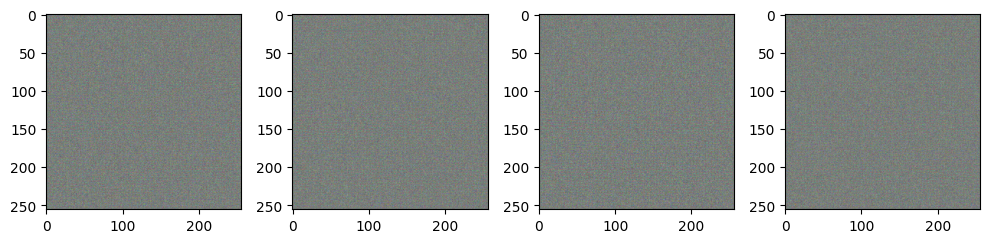

In [15]:
gen.eval()
with torch.inference_mode():
    gen_imgs = gen(torch.randn(4,z_dim))
    print(gen_imgs.shape)

# Plot generated images
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 10))
for i in range(4):
    axes[i].imshow(torch.permute(gen_imgs[i], (1,2,0)))
fig.tight_layout()
fig.show()

In [16]:
# Send the generator to device
gen = gen.to(device)

### Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size):
        super().__init__()
        self.img_channels = img_channels
        self.img_size = img_size
        
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * (img_size // 16) * (img_size // 16), 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )
        
    def forward(self, x):
        return self.disc(x)

In [18]:
# Test discriminator
random_img = torch.randn(3,3,256,256)
img_channels = 3
img_size = 256
disc = Discriminator(img_channels, img_size)
disc(random_img)

tensor([[0.5333],
        [0.5756],
        [0.5275]], grad_fn=<SigmoidBackward0>)

In [19]:
# Send the discriminator to device
disc = disc.to(device)

## Training

In [20]:
Z_DIM = 128
gen_lr = 1e-4
disc_lr = 1e-5
NUM_EPOCHS = 3000
FIXED_NOISE = torch.randn(BATCH_SIZE, Z_DIM)

gen_opt = torch.optim.Adam(gen.parameters(), lr = gen_lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr = disc_lr)
criterion = nn.BCELoss()

In [21]:
for epoch in range(NUM_EPOCHS):
    for batch, (real, _) in enumerate(loader):
        real = real.to(device)
        
        # Train Discriminator
        noise = torch.randn(BATCH_SIZE, Z_DIM).to(device)
        fake = gen(noise)
        disc_real = disc(real)
        dloss_real = criterion(disc_real, torch.ones_like(disc_real)) # 1 -> real
        disc_fake = disc(fake)
        dloss_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # 0 -> fake
        dloss = (dloss_real + dloss_fake) / 2
        
        disc.zero_grad()
        dloss.backward(retain_graph = True)
        disc_opt.step()
        
        # Train Generator
        output = disc(fake)
        gloss = criterion(output, torch.ones_like(output)) 
        gen.zero_grad()
        gloss.backward()
        gen_opt.step()
        
        if batch == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch}/{len(loader)} \
                      Loss D: {dloss.item():.4f}, loss G: {gloss.item():.4f}"
            )

Epoch [0/3000] Batch 0/15                       Loss D: 0.7547, loss G: 0.8046
Epoch [1/3000] Batch 0/15                       Loss D: 0.4949, loss G: 1.2502
Epoch [2/3000] Batch 0/15                       Loss D: 0.5553, loss G: 1.6480
Epoch [3/3000] Batch 0/15                       Loss D: 0.5027, loss G: 1.5102
Epoch [4/3000] Batch 0/15                       Loss D: 0.3954, loss G: 1.9631
Epoch [5/3000] Batch 0/15                       Loss D: 0.1951, loss G: 1.9513
Epoch [6/3000] Batch 0/15                       Loss D: 0.1254, loss G: 2.5637
Epoch [7/3000] Batch 0/15                       Loss D: 0.1801, loss G: 2.1813
Epoch [8/3000] Batch 0/15                       Loss D: 0.1046, loss G: 3.2204
Epoch [9/3000] Batch 0/15                       Loss D: 0.0643, loss G: 3.0862
Epoch [10/3000] Batch 0/15                       Loss D: 0.0502, loss G: 3.0192
Epoch [11/3000] Batch 0/15                       Loss D: 0.0400, loss G: 3.6852
Epoch [12/3000] Batch 0/15                       L

## Creating Images

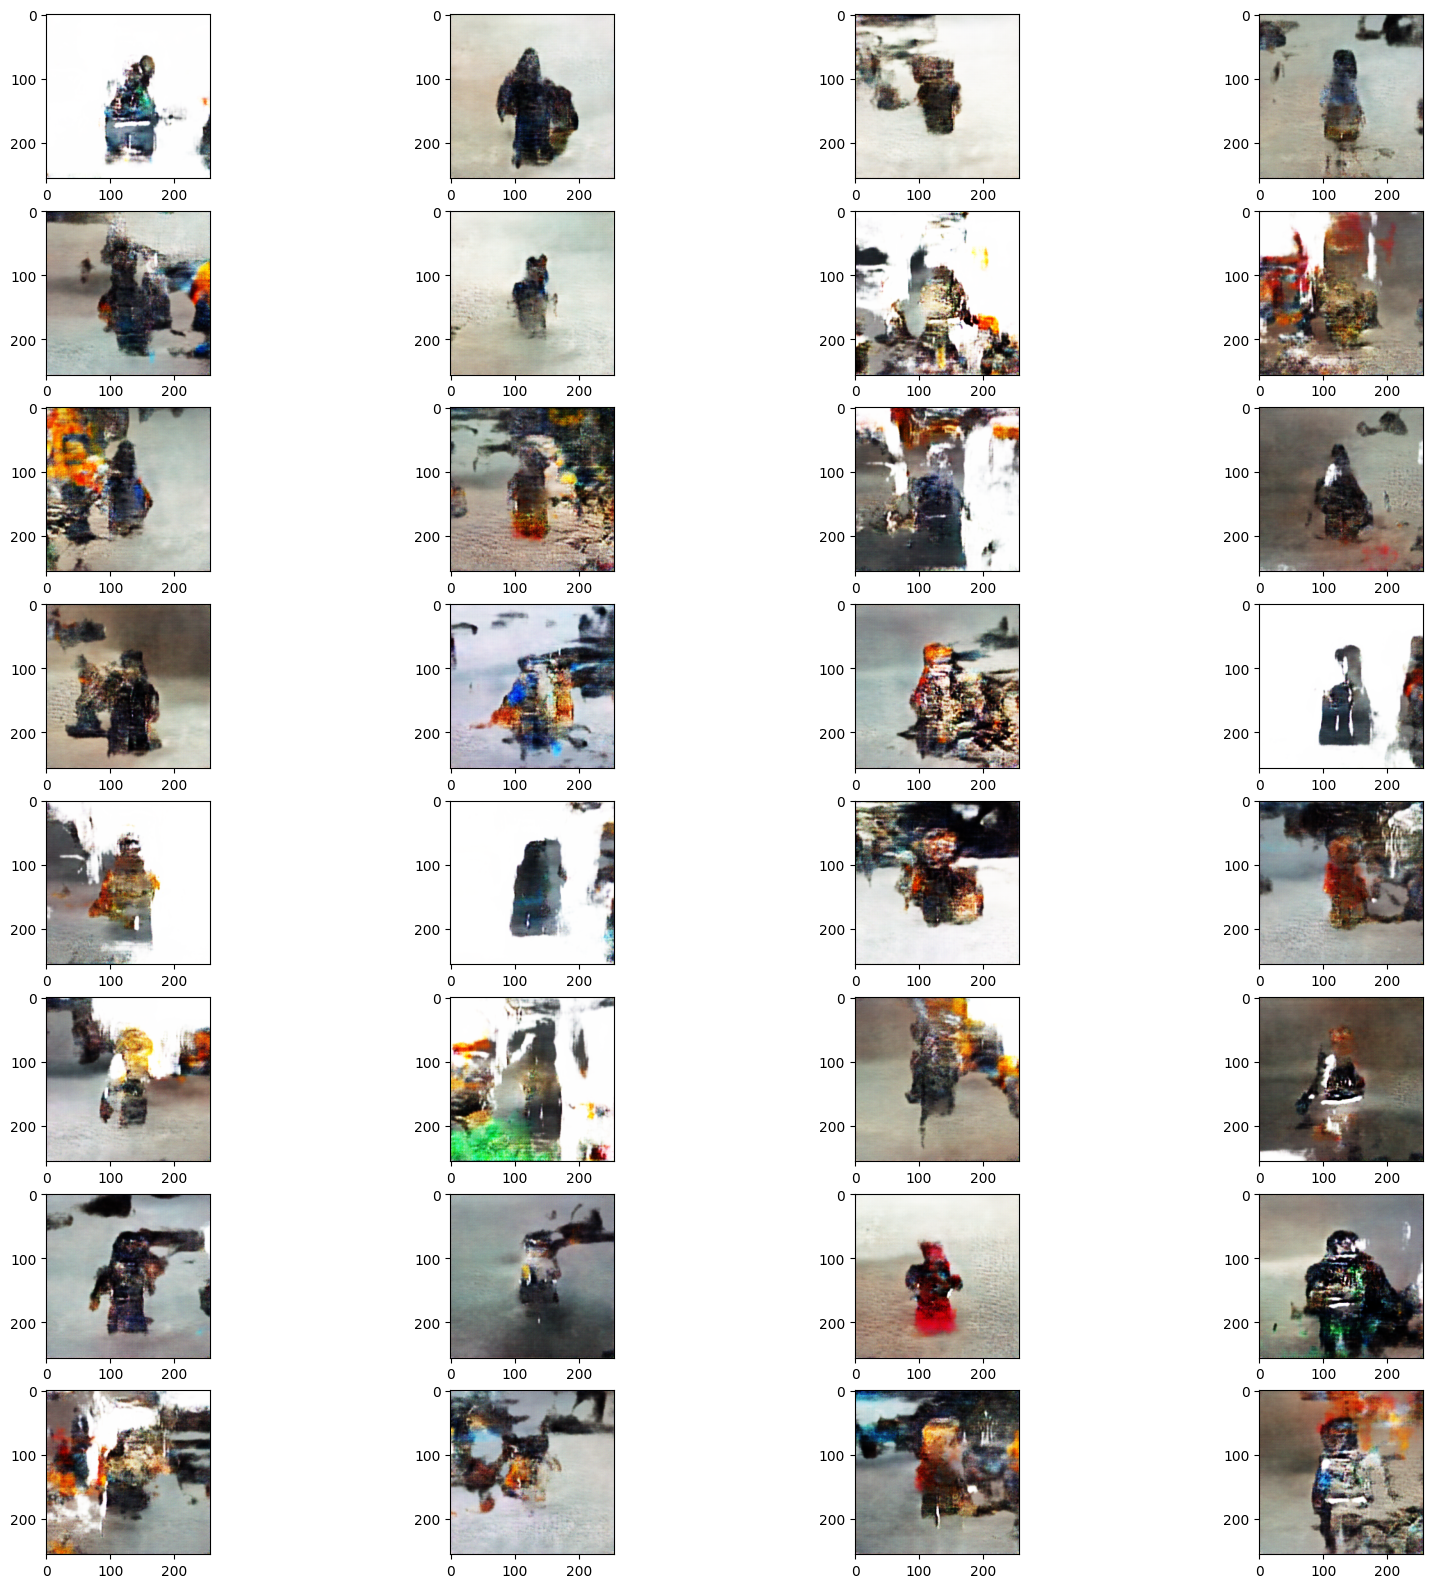

In [22]:
with torch.inference_mode():
    gen_images = gen(FIXED_NOISE.to(device))
    
fig = plt.figure(figsize = (20,20))
for i in range(BATCH_SIZE):
    ax = fig.add_subplot(8,4,i+1)
    ax.imshow(torch.permute(gen_images[i].cpu(), (1, 2, 0)))